# **Clasificación de texto con T5 para ver si es phishing**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# Load the dataset
df = pd.read_csv('C:/Users/Bryan/codigo/Transformer_Phishing_Tesis/Data/phishing_dataset.csv')

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['contexts'], df['phishing'], test_size=0.2, stratify=df['phishing'])

# Tokenize the data using the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
# Tokenize the data using the T5 tokenizer with truncation and padding
train_encodings = tokenizer(list(X_train), truncation=True, padding="max_length", max_length=200, return_tensors='tf')
test_encodings = tokenizer(list(X_test), truncation=True, padding="max_length", max_length=200, return_tensors='tf')
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(32)


from transformers import TFT5ForConditionalGeneration

class T5ClassificationModel(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.t5 = TFT5ForConditionalGeneration.from_pretrained(model_name)
        self.classifier = tf.keras.layers.Dense(num_labels, activation='softmax')
    
    def call(self, input_ids, attention_mask=None):
        outputs = self.t5(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)
        hidden_states = outputs.encoder_last_hidden_state[:, 0, :]
        logits = self.classifier(hidden_states)
        return logits

model = T5ClassificationModel('t5-small', num_labels=2)
# Especificar una tasa de aprendizaje personalizada para el optimizador Adam
learning_rate = 3e-5
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=test_dataset, epochs=5)
model.evaluate(test_dataset)

c:\Users\Bryan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were init

Epoch 1/5
244/244 [==============================] - 4356s 18s/step - loss: 0.4069 - accuracy: 0.8709 - val_loss: 0.3272 - val_accuracy: 0.8802
Epoch 2/5
244/244 [==============================] - 4387s 18s/step - loss: 0.3265 - accuracy: 0.8800 - val_loss: 0.2889 - val_accuracy: 0.8802
Epoch 3/5
244/244 [==============================] - 4352s 18s/step - loss: 0.2902 - accuracy: 0.8829 - val_loss: 0.2555 - val_accuracy: 0.8899
Epoch 4/5
244/244 [==============================] - 4332s 18s/step - loss: 0.2578 - accuracy: 0.8881 - val_loss: 0.2298 - val_accuracy: 0.9048
Epoch 5/5
62/62 [==============================] - 298s 5s/step - loss: 0.2106 - accuracy: 0.9171


[0.2105906456708908, 0.9170507192611694]

In [ ]:
test_predictions = model.predict(test_dataset)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Suponiendo que 'y_test' es un numpy array. Si no lo es, primero conviértelo usando y_test.to_numpy() o una operación similar
# Las predicciones están en formato softmax (probabilidades), así que necesitas convertirlas a etiquetas
y_pred = tf.argmax(test_predictions.logits, axis=1).numpy()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)


In [ ]:
from sklearn.metrics import roc_auc_score

# Esto es para clasificación binaria. Asegúrate de ajustar según sea necesario para casos multiclase.
# Asume que y_test es binario y que las predicciones contienen probabilidades para la clase positiva.
roc_auc = roc_auc_score(y_test, test_predictions.logits[:,1]) # Ajusta los índices según sea necesario
print(f"ROC-AUC Score: {roc_auc}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Suponiendo que test_predictions.logits[:, 1] te da las probabilidades de la clase positiva
# Asegúrate de que y_test está correctamente formateado como un array de 0s y 1s
fpr, tpr, thresholds = roc_curve(y_test, test_predictions.logits[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
probabilidades = tf.nn.softmax(test_predictions.logits, axis=1)[:, 1]

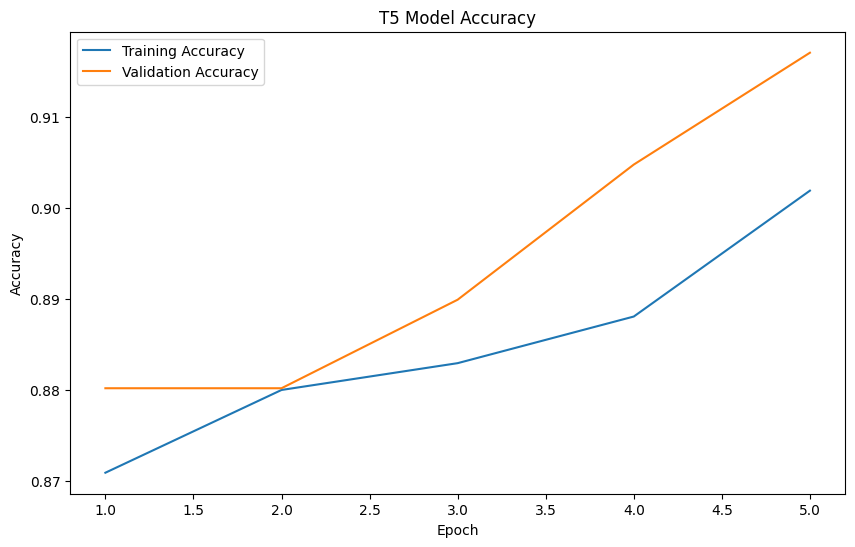

In [2]:
# La historia de entrenamiento contiene los registros de precisión para el entrenamiento y la validación
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1, len(accuracy_train) + 1)

# Ahora puedes crear el gráfico utilizando Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_train, label='Training Accuracy')
plt.plot(epochs, accuracy_val, label='Validation Accuracy')
plt.title('T5 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()